# Team
- **Tommaso Giordano**,
- **Guido Gonnella**,
- **Andrea Migliorini**,
- **Simone Oggioni**,
- **Luca Olivieri**.

**Video**: https://drive.google.com/file/d/1PacfOhmIsuAtYV4P8HEvrRlB0yHz85rb/view?usp=share_link

---

# Setup

In [ ]:
!git clone https://github.com/pubmedqa/pubmedqa.git
!pip install -q datasets

Cloning into 'pubmedqa'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 40 (delta 0), reused 1 (delta 0), pack-reused 37 (from 1)
Receiving objects: 100% (40/40), 704.87 KiB | 9.79 MiB/s, done.
Resolving deltas: 100% (12/12), done.


Standard libraries:

In [ ]:
import json
import string
import re
import gc
from typing import List
from collections import Counter
from time import time
import warnings
import os

Viz libraries:

In [ ]:
from IPython.display import Markdown
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

ML libraries:

In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
!pip install -q umap-learn
from umap import UMAP
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity

NLP libraries:

In [ ]:
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import sentence_transformers
from sentence_transformers import SentenceTransformer

In [ ]:
SEED = 42

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

---

# 0.0 Ingestion

In [ ]:
def remove_punctuation(text):
    return re.sub(r'['+re.escape(string.punctuation)+']', '', text)

def merge_context(row, include_contexts, include_lables, include_meshes):
    s = ""
    if include_contexts:
        s += ' ' + ' '.join(row['context']['contexts'])
    if include_lables:
        s += ' ' + ' '.join(row['context']['labels'])
    if include_meshes:
        s += ' ' + ' '.join(row['context']['meshes'])
    s = remove_punctuation(s)
    return s

def download_and_process_dataframes(include_contexts=True, include_labels=False, include_meshes=True):
    artificial = pd.read_parquet("hf://datasets/qiaojin/PubMedQA/pqa_artificial/train-00000-of-00001.parquet").sort_values(by=['pubid'])
    labeled = pd.read_parquet("hf://datasets/qiaojin/PubMedQA/pqa_labeled/train-00000-of-00001.parquet").sort_values(by=['pubid'])
    unlabeled = pd.read_parquet("hf://datasets/qiaojin/PubMedQA/pqa_unlabeled/train-00000-of-00001.parquet").sort_values(by=['pubid'])

    # Join context
    artificial['context'] = artificial.apply(lambda row: merge_context(row, include_contexts=include_contexts, include_lables=include_labels, include_meshes=True), axis=1)
    labeled['context'] = labeled.apply(lambda row: merge_context(row, include_contexts=include_contexts, include_lables=include_labels, include_meshes=True), axis=1)
    unlabeled['context'] = unlabeled.apply(lambda row: merge_context(row, include_contexts=include_contexts, include_lables=include_labels, include_meshes=True), axis=1)
    # Remove punctuation
    artificial['question'] = artificial.apply(lambda row: remove_punctuation(row['question']), axis=1)
    labeled['question'] = labeled.apply(lambda row: remove_punctuation(row['question']), axis=1)
    unlabeled['question'] = unlabeled.apply(lambda row: remove_punctuation(row['question']), axis=1)
    return artificial, labeled, unlabeled

In [ ]:
df_a, df_l, df_u = download_and_process_dataframes()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
with open('/content/pubmedqa/data/test_ground_truth.json') as f:
    data = json.load(f)

test_df = pd.DataFrame.from_dict(data, orient='index')
test_df = test_df.rename(columns={0: "final_decision"})
test_df.index = test_df.index.astype(int)
test_df.sort_index(ascending=True)
test_df["pubid"] = test_df.index
test_df.index = range(len(test_df))
test_df = test_df[["pubid", "final_decision"]]
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   pubid           500 non-null    int64 
 1   final_decision  500 non-null    object
dtypes: int64(1), object(1)
memory usage: 7.9+ KB


---

# 1.1 Preliminary Analysis

## Data Exploration

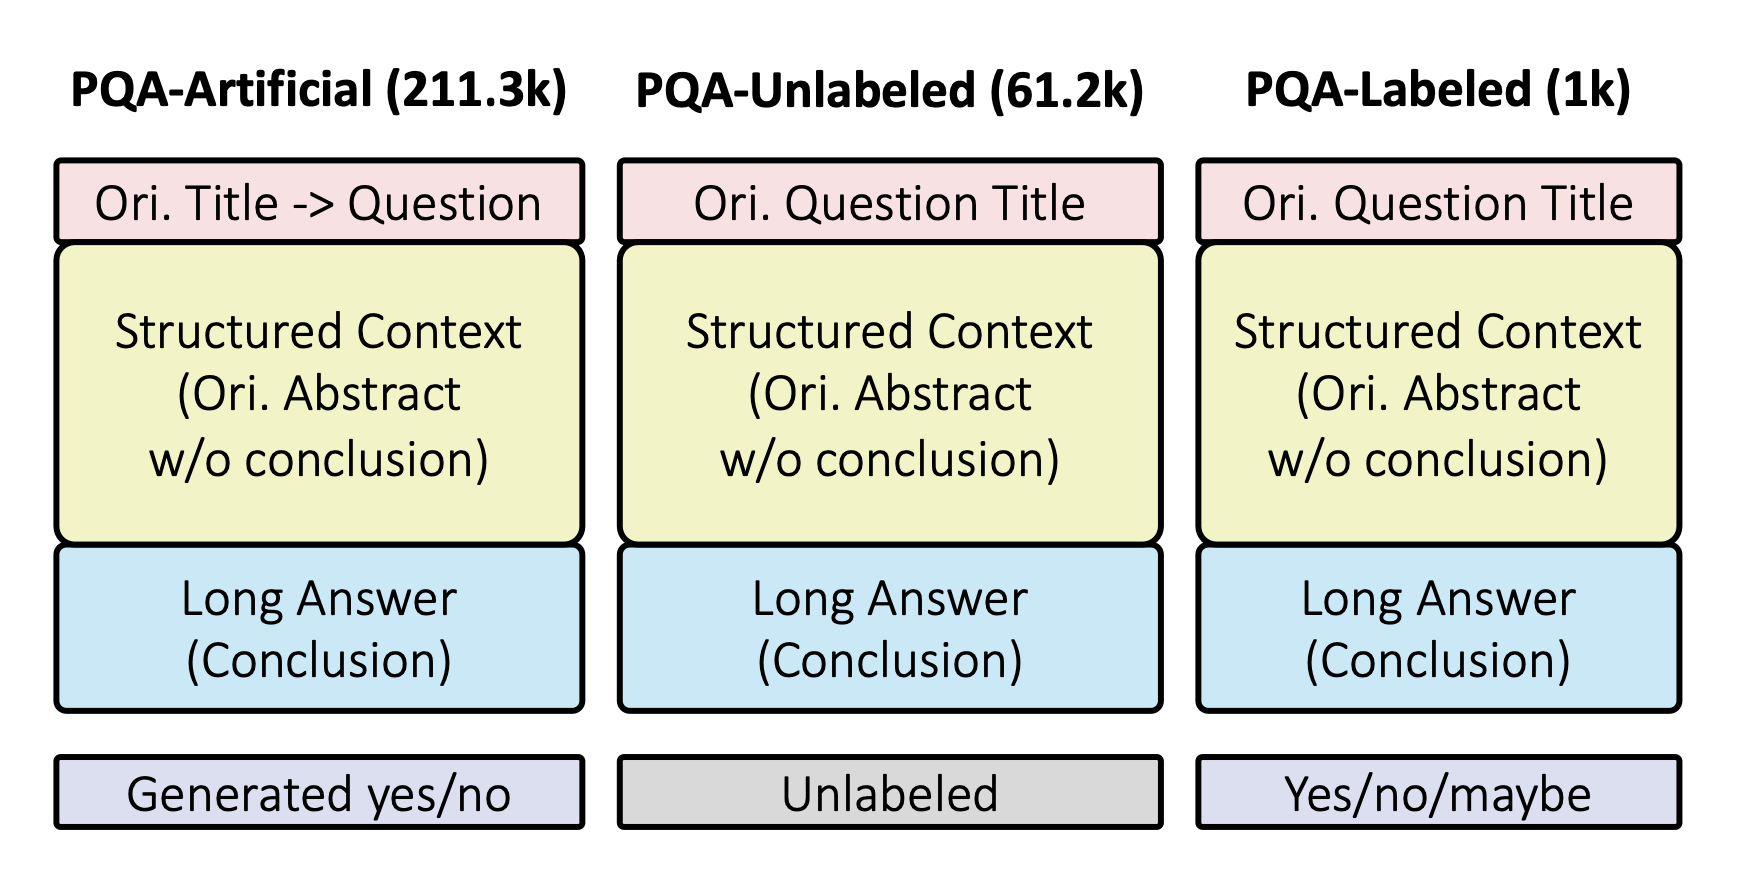

There are three **datasets**:
- `PQA-A`: 211,269 samples synthentically labeled by GPT-4.
- `PQA-U`: 61,249 samples unlabeled.
- `PQA-L`: 1000 human-labeled samples (500 for cross-validation, 500 for testing).

Dataset **fields**:
- `question`: extract from medical papers *title*.
- `context`: extract from medical papers *abstract*.
- `long_answer`: extract from medical papers *conclusion*.
- `final_decision`: human-labeled or synthethically-labeled.

In [ ]:
PQA_A = pd.read_parquet("hf://datasets/qiaojin/PubMedQA/pqa_artificial/train-00000-of-00001.parquet")
PQA_A = PQA_A.sort_values(by=['pubid'])
PQA_A.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211269 entries, 133125 to 119288
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   pubid           211269 non-null  int32 
 1   question        211269 non-null  object
 2   context         211269 non-null  object
 3   long_answer     211269 non-null  object
 4   final_decision  211269 non-null  object
dtypes: int32(1), object(4)
memory usage: 8.9+ MB


In [ ]:
PQA_L = pd.read_parquet("hf://datasets/qiaojin/PubMedQA/pqa_labeled/train-00000-of-00001.parquet")
PQA_L = PQA_L.sort_values(by=['pubid'])
PQA_L.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 169 to 80
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   pubid           1000 non-null   int32 
 1   question        1000 non-null   object
 2   context         1000 non-null   object
 3   long_answer     1000 non-null   object
 4   final_decision  1000 non-null   object
dtypes: int32(1), object(4)
memory usage: 43.0+ KB


In [ ]:
PQA_U = pd.read_parquet("hf://datasets/qiaojin/PubMedQA/pqa_unlabeled/train-00000-of-00001.parquet")
PQA_U = PQA_U.sort_values(by=['pubid'])
PQA_U.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61249 entries, 7318 to 7857
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   pubid        61249 non-null  int32 
 1   question     61249 non-null  object
 2   context      61249 non-null  object
 3   long_answer  61249 non-null  object
dtypes: int32(1), object(3)
memory usage: 2.1+ MB


No duplicates of `pubid`, it can be treated as a index:

In [ ]:
print(PQA_A["pubid"].duplicated().sum())
print(PQA_L["pubid"].duplicated().sum())
print(PQA_U["pubid"].duplicated().sum())

0
0
0


In [ ]:
with open('/content/pubmedqa/data/test_ground_truth.json') as f:
    data = json.load(f)

test_df = pd.DataFrame.from_dict(data, orient='index')
test_df = test_df.rename(columns={0: "final_decision"})
test_df.index = test_df.index.astype(int)
test_df.sort_index(ascending=True)
test_df["pubid"] = test_df.index
test_df.index = range(len(test_df))
test_df = test_df[["pubid", "final_decision"]]
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   pubid           500 non-null    int64 
 1   final_decision  500 non-null    object
dtypes: int64(1), object(1)
memory usage: 7.9+ KB


In [ ]:
print(test_df["pubid"].duplicated().sum())

0


In [ ]:
all(elem in list(PQA_L["pubid"]) for elem in list(test_df["pubid"]))

True

The test set is a subset of 500 out of the 1000 samples in the PQA-L set.

The data exploration phase is conducted on the data obtained merging all dataset:
- `PQA-A` has to be considered because it makes up for most of the data points.
- `PQA-L` has to be considered because answers come from a different distribution, hence they might contain novel and valuable info.
- `PQA-U` has to be considered because it holds a significant amount of data points.

To perform some analysis on the language statistics that may differ across the `question`, `context` and `long_answer` fields, I keep them separated.

### Target distribution

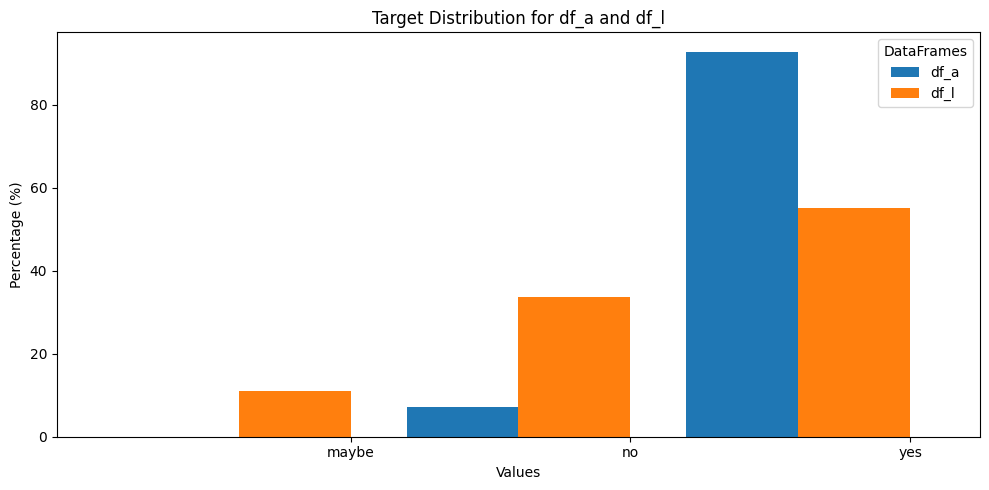

In [ ]:
# Compute value frequencies for both dataframes
freq_a = df_a['final_decision'].value_counts()
freq_l = df_l['final_decision'].value_counts()

# Calculate percentages for both dataframes
perc_a = (freq_a / len(df_a)) * 100
perc_l = (freq_l / len(df_l)) * 100

# Combine both series into one DataFrame for easier plotting
combined = pd.DataFrame({
    'df_a': perc_a,
    'df_l': perc_l
}).fillna(0)  # Fill missing values with 0 to avoid issues

# Create a plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot both datasets
combined.plot(kind='bar', ax=ax, width=0.8, position=1)

# Add labels and title
ax.set_title('Target Distribution for df_a and df_l')
ax.set_xlabel('Values')
ax.set_ylabel('Percentage (%)')
ax.set_xticks(range(len(combined)))  # Ensure the x-ticks match the number of categories
ax.set_xticklabels(combined.index, rotation=0)  # Properly label the x-ticks
ax.legend(title='DataFrames')

# Display the plot
plt.tight_layout()
plt.show()

- **PQA-L** comprise samples from all classes but with varying representation. Indeed, the `'yes'` class is over-represented (55.2%), while the `'maybe'` class is severily under-represented (11%).
- **PQA-A** is mostly composed of `'yes'` samples (92.8%) as opposed to `'no'` samples (only 7.2%), but, most importantly, it has no `'maybe'` samples!
- **PQA-U** has no labels at all.

### Word count

First, I want all fields in purely textual format. Hence, I concatenate the text coming in the `context` field (since it is in a `dict` format):

Then, let's extract the first `N = 1000` splitted and lower-cased words:

In [ ]:
N = 1000

sampled_idxs = df_a.index.to_series().sample(n=N, replace=False, random_state=SEED)

In [ ]:
nltk.download('stopwords')

def split_and_clean_docs(docs: List[str], remove_stopwords: bool = True):
    docs_split = sorted([w.lower() for doc in docs for w in doc.split()])
    if remove_stopwords:
        docs_split = [w.lower() for doc in docs_split for w in doc.split() if w not in stopwords.words('english')]
    return docs_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
question_split_with_stopwords = split_and_clean_docs(list(df_a["question"].loc[sampled_idxs]),
                                      remove_stopwords=False)

In [ ]:
question_counts_with_stopwords = nltk.FreqDist(question_split_with_stopwords)
print(f"vocab size: {len(question_counts_with_stopwords.most_common())}")
question_counts_with_stopwords.most_common(20)

vocab size: 4507


[('in', 639),
 ('of', 583),
 ('does', 494),
 ('and', 331),
 ('with', 329),
 ('the', 281),
 ('is', 278),
 ('a', 195),
 ('do', 139),
 ('to', 139),
 ('associated', 137),
 ('for', 114),
 ('patients', 114),
 ('by', 101),
 ('are', 93),
 ('cells', 86),
 ('after', 61),
 ('cancer', 57),
 ('cell', 50),
 ('expression', 50)]

Clearly, most of the weight in this metrics is upon stopwords that do not carry much semantic information. Let's remove them:

In [ ]:
question_split = split_and_clean_docs(list(df_a["question"].loc[sampled_idxs]),
                                      remove_stopwords=True)

In [ ]:
question_counts = nltk.FreqDist(question_split)
print(f"vocab size: {len(question_counts.most_common())}")
question_counts.most_common(20)

vocab size: 4445


[('associated', 137),
 ('patients', 114),
 ('cells', 86),
 ('cancer', 57),
 ('cell', 50),
 ('expression', 50),
 ('disease', 47),
 ('human', 46),
 ('activity', 40),
 ('factor', 40),
 ('inhibit', 39),
 ('injury', 39),
 ('acute', 37),
 ('predict', 37),
 ('children', 33),
 ('gene', 33),
 ('activation', 32),
 ('mice', 32),
 ('protein', 32),
 ('receptor', 32)]

From now on, I will never consider stopwords anymore.

Now let's compute the same result from the `long_answer` and `context`:

In [ ]:
answer_split = split_and_clean_docs(list(df_a["long_answer"].loc[sampled_idxs]),
                                    remove_stopwords=True)
answer_counts = nltk.FreqDist(answer_split)

In [ ]:
context_split = split_and_clean_docs(list(df_a["context"].loc[sampled_idxs]),
                                     remove_stopwords=True)
context_counts = nltk.FreqDist(context_split)

Let's merge the questions and contexts as input:

In [ ]:
input_split = context_split + question_split
input_counts = nltk.FreqDist(input_split)

Let's merge the counts and find out the 30 most common words to have an idea of the distribution:

In [ ]:
all_split = split_and_clean_docs(
    list(df_a["long_answer"].loc[sampled_idxs]) + list(df_a["context"].sample(N, random_state=SEED)) + list(df_a["question"].loc[sampled_idxs]),
    remove_stopwords=True)
all_counts = nltk.FreqDist(answer_split)

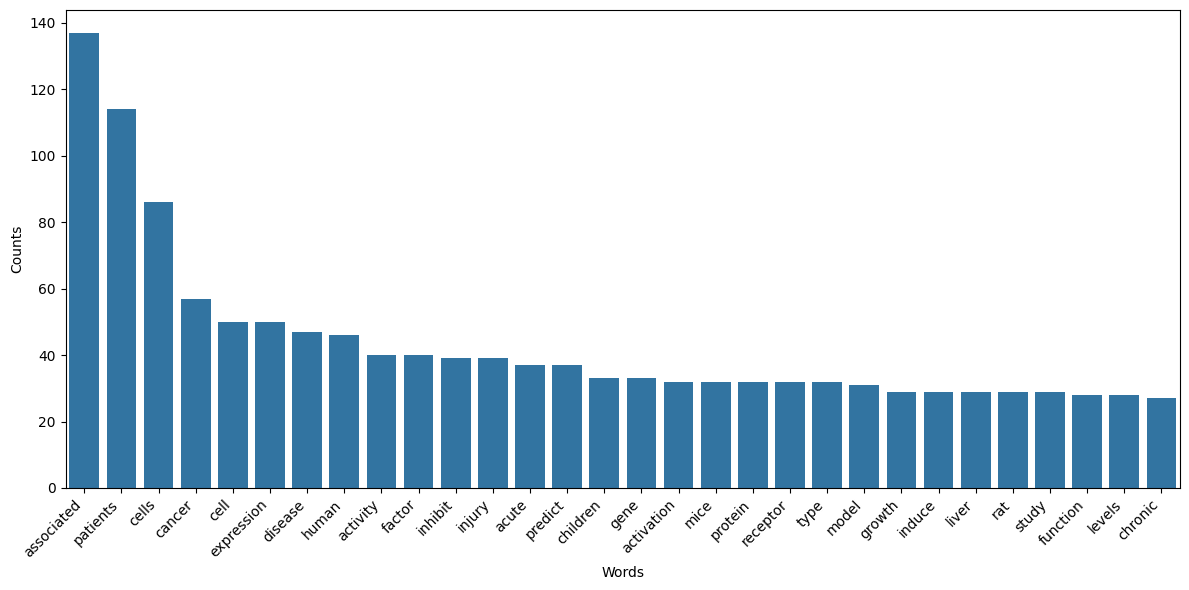

In [ ]:
all_df = pd.DataFrame(question_counts.most_common(30), columns=['Word', 'Counts'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Word', y='Counts', data=all_df)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.tight_layout()
plt.show()

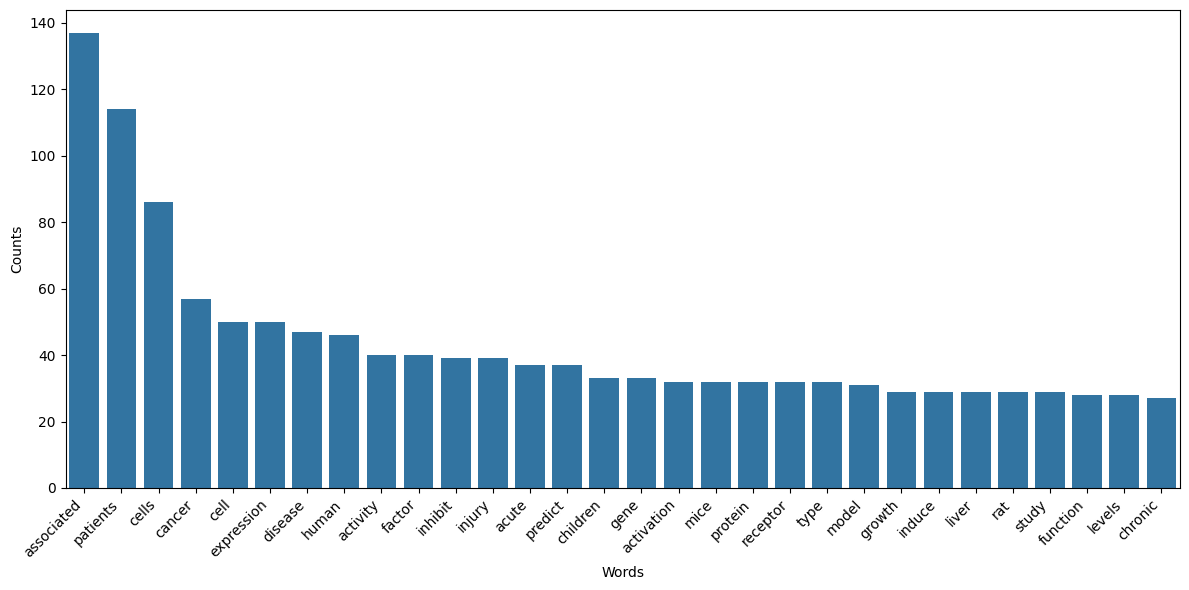

In [ ]:
question_df = pd.DataFrame(question_counts.most_common(30), columns=['Word', 'Counts'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Word', y='Counts', data=question_df)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.tight_layout()
plt.show()

We can clearly notice the **Zipf's law** at it work here! If we consider more words the trend continues regularly as expected.

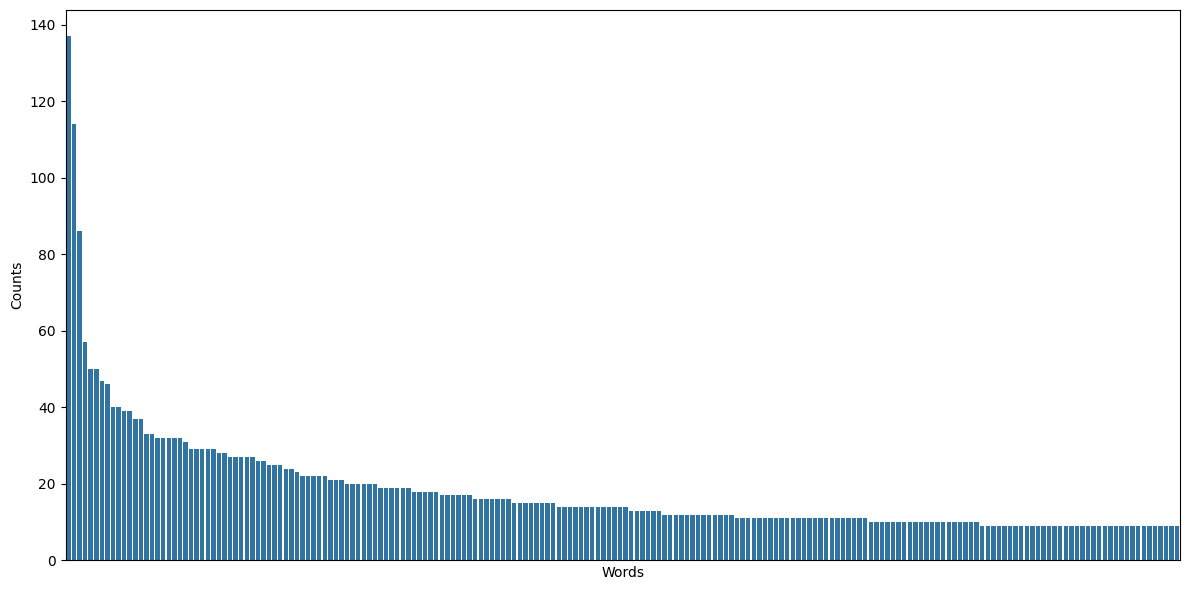

In [ ]:
question_df = pd.DataFrame(question_counts.most_common(200), columns=['Word', 'Counts'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Word', y='Counts', data=question_df)
plt.xticks([], [])
plt.xlabel('Words')
plt.ylabel('Counts')
plt.tight_layout()
plt.show()

In [ ]:
print(f'Number of entries: {len(df_a["question"])}\n')

question_sizes = [len(q.split()) for q in df_a["question"]]
print("QUESTIONS length:")
print(f'Average: {np.mean(question_sizes).round(2)}')
print(f'Minimum: {np.min(question_sizes)}')
print(f'Maximum: {np.max(question_sizes)}\n')

context_sizes = [len(q.split()) for q in df_a["context"]]
print("CONTEXTS length:")
print(f'Average: {np.mean(context_sizes).round(2)}')
print(f'Minimum: {np.min(context_sizes)}')
print(f'Maximum: {np.max(context_sizes)}\n')

answer_sizes = [len(q.split()) for q in df_a["long_answer"]]
print("ANSWERS length:")
print(f'Average: {np.mean(answer_sizes).round(2)}')
print(f'Minimum: {np.min(answer_sizes)}')
print(f'Maximum: {np.max(answer_sizes)}\n')

input_sizes = [question_sizes[i]+context_sizes[i] for i in range(len(question_sizes))]

Number of entries: 211269

QUESTIONS length:
Average: 15.08
Minimum: 3
Maximum: 99

CONTEXTS length:
Average: 225.17
Minimum: 2
Maximum: 1001

ANSWERS length:
Average: 37.59
Minimum: 1
Maximum: 510



Let's display the histograms of the word counts of the fields separately:

In [ ]:
def display_histplot(data: List, title: str, xlabel: str, ylabel: str, bins: int = 100, ax = None):
    sns.histplot(data, ax=ax, bins=bins)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

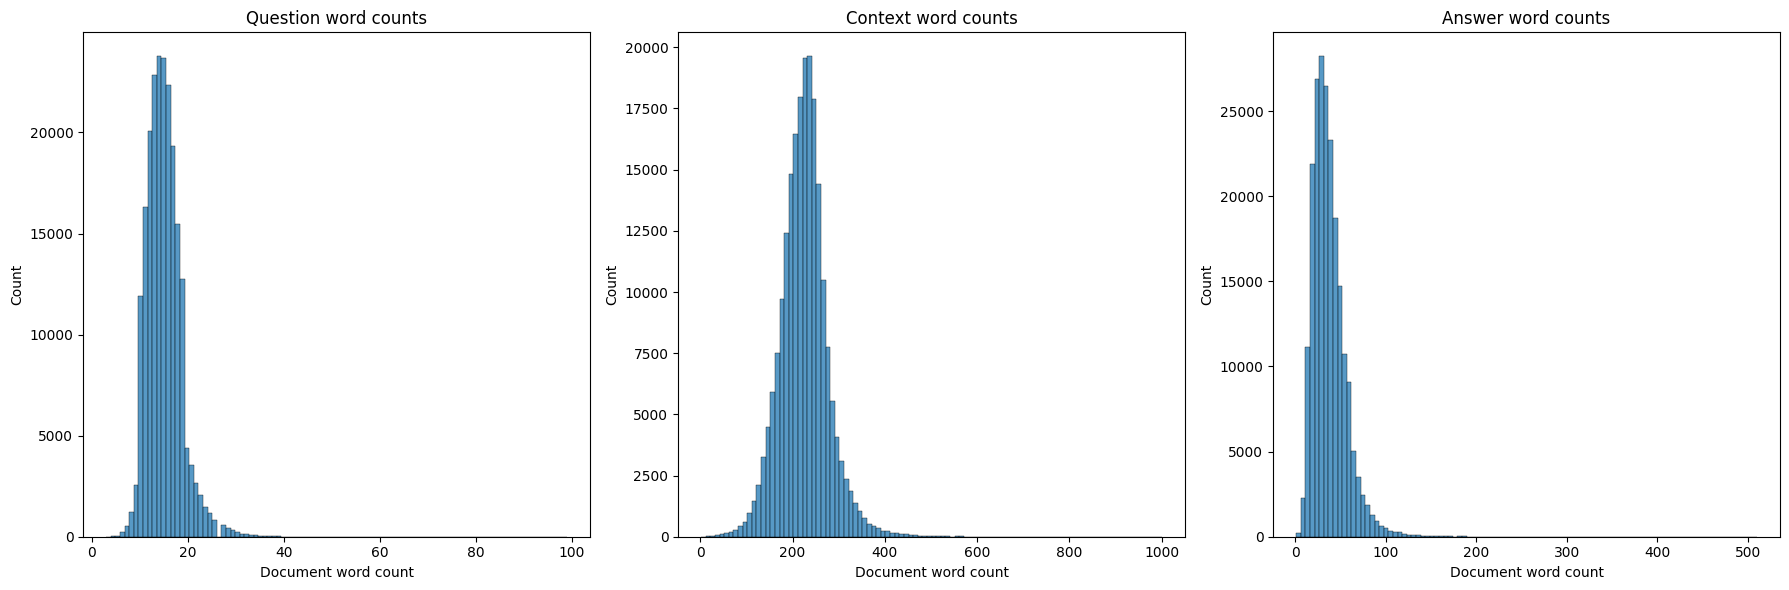

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
display_histplot(question_sizes, 'Question word counts', 'Document word count', 'Count', ax=axs[0], bins=100)
display_histplot(context_sizes, 'Context word counts', 'Document word count', 'Count', ax=axs[1], bins=100)
display_histplot(answer_sizes, 'Answer word counts', 'Document word count', 'Count', ax=axs[2], bins=100)
plt.tight_layout()

Let's display them together:

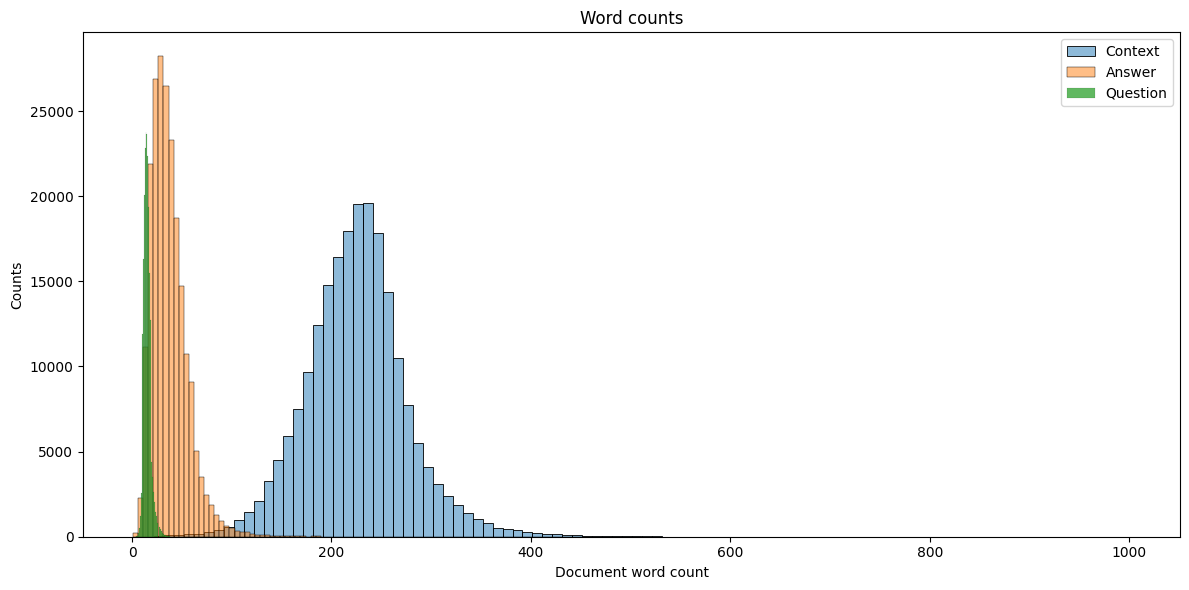

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(context_sizes, bins=100, label="Context", alpha=0.5)
sns.histplot(answer_sizes, bins=100, label="Answer", alpha=0.5)
sns.histplot(question_sizes, bins=100, label="Question", alpha=0.75)
plt.title("Word counts")
plt.xlabel("Document word count")
plt.ylabel("Counts")
plt.legend()
plt.tight_layout()

The tail looks suspicious, let's perform some manual investigation:

In [ ]:
[doc for doc in df_a["question"] if len(doc) >= 400]

['Are renal outcomes and mortality following hydroxyethyl starch resuscitation of critically ill patients  systematic review and metaanalysis of randomized trials  ATTENTION  The analysis and conclusions of this article being revised by the authors  This is due to the journal Anesthesia and Analgesia s retraction of a paper by Dr Joachim Boldt  an author in seven of the studies analyzed in this review  As such  the editors of Open Medicine recommend interpreting this review with extreme caution until Zarychanski et al  publish a new analysis and interpretation in Open Medicine  For more information  see Anesthesia and Analgesia s press release']

In [ ]:
[doc for doc in df_a["question"] if len(doc) <= 20]

['Is your child dead', 'Is the cup half full', 'Is trauma danger']

This looks fine, it's just a long question.

In [ ]:
[doc for doc in df_a["long_answer"] if len(doc) >= 3200]

["1. Single nerve fibre action potentials (APs) of lower sacral nerve roots were recorded extracellularly with 2 pairs of wire electrodes during an operation for implanting an anterior root stimulator for bladder control in 9 humans with a spinal cord injury and a dyssynergia of the urinary bladder. Roots that were not saved and that were used to record from were later used for morphometry. 2. Nerve fibre groups were identified by conduction velocity distribution histograms of single afferent and efferent fibres and partly by nerve fibre diameter distribution histograms, and correlation analysis was performed. Group conduction velocity values were obtained additionally from compound action potentials (CAPs) evoked by electrical stimulation of nerve roots and the urinary bladder. 3. The group conduction velocities and group nerve fibre diameters had the following pair-values at 35.5 degrees C: Spindle afferents: SP1 (65 m/s / 13.1 microm), SP2 (51/12.1); touch afferents: T1 (47/11.1), T

In [ ]:
[doc for doc in df_a["long_answer"] if len(doc) <= 3]

['and', 'H', 'E', 'T', 'SUV', 'H', 'P', 'IMD', 'T', 'SUV', 'H']

In [ ]:
[doc for doc in df_a["context"] if len(doc) >= 5750]

[]

In [ ]:
[doc for doc in df_a["context"] if len(doc) <= 26]

[' NONE DECLARED ']

All fields contains some anomalies.

Let's visualise some input-output joint length distribution:

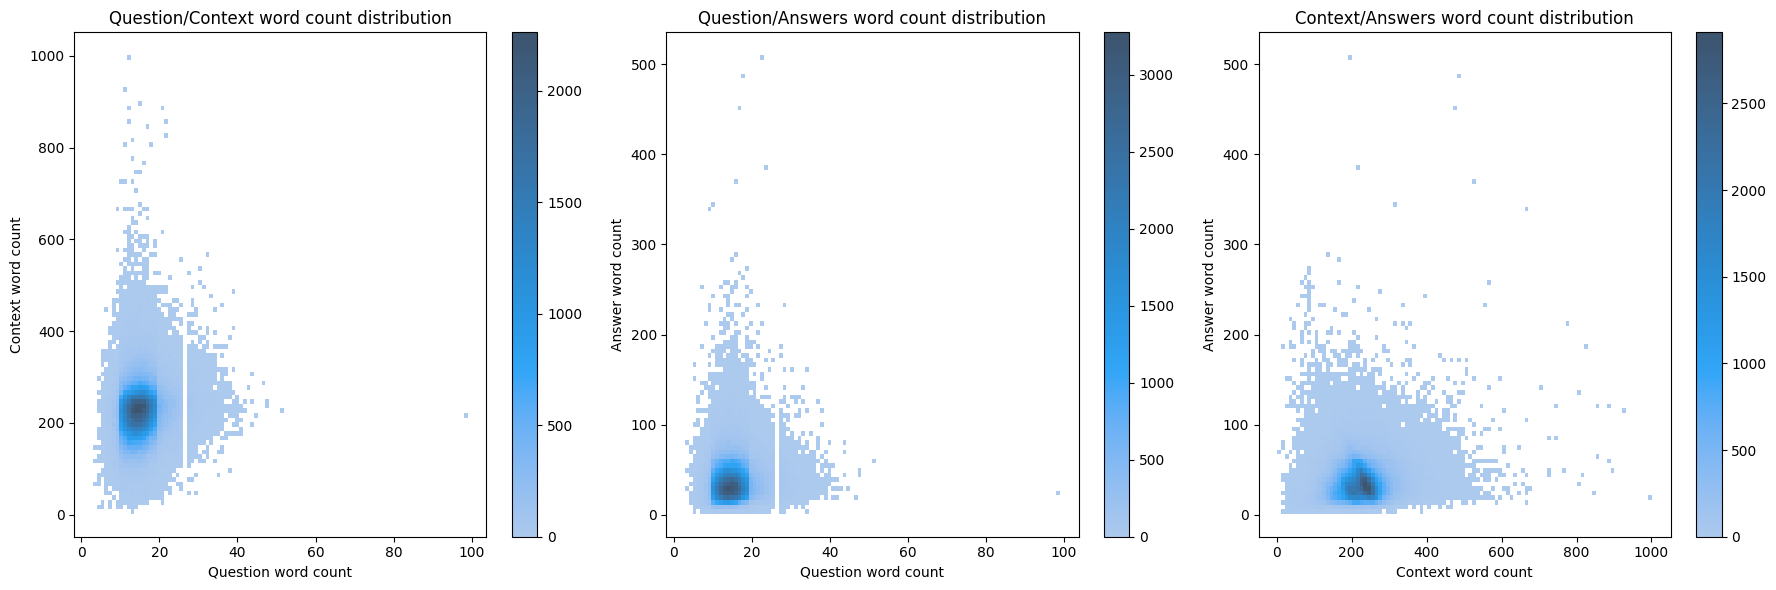

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

ax=axs[0]
plot = sns.histplot(x=question_sizes, y=context_sizes, bins=100, cbar=True, ax=ax)
ax.set_xlabel('Question word count')
ax.set_ylabel('Context word count')
ax.set_title("Question/Context word count distribution")

ax=axs[1]
sns.histplot(x=question_sizes, y=answer_sizes, bins=100, cbar=True, ax=ax)
ax.set_xlabel('Question word count')
ax.set_ylabel('Answer word count')
ax.set_title("Question/Answers word count distribution")

ax=axs[2]
sns.histplot(x=context_sizes, y=answer_sizes, bins=100, cbar=True, ax=ax)
ax.set_xlabel('Context word count')
ax.set_ylabel('Answer word count')
ax.set_title("Context/Answers word count distribution")

plt.tight_layout()

Text(0.5, 1.0, 'Input/Answer word count distribution')

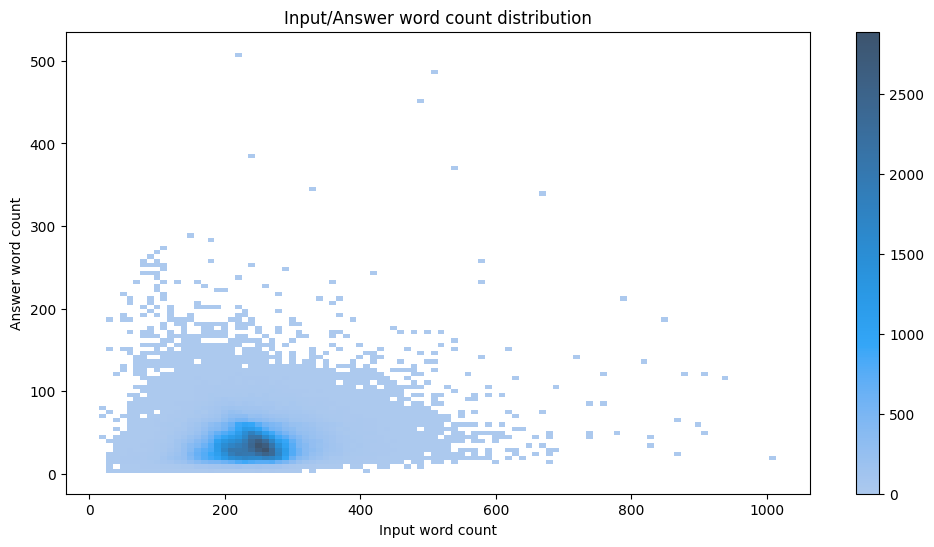

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(x=input_sizes, y=answer_sizes, bins=100, cbar=True)
plt.xlabel('Input word count')
plt.ylabel('Answer word count')
plt.title("Input/Answer word count distribution")

### Word Clouds

In [ ]:
M = 20

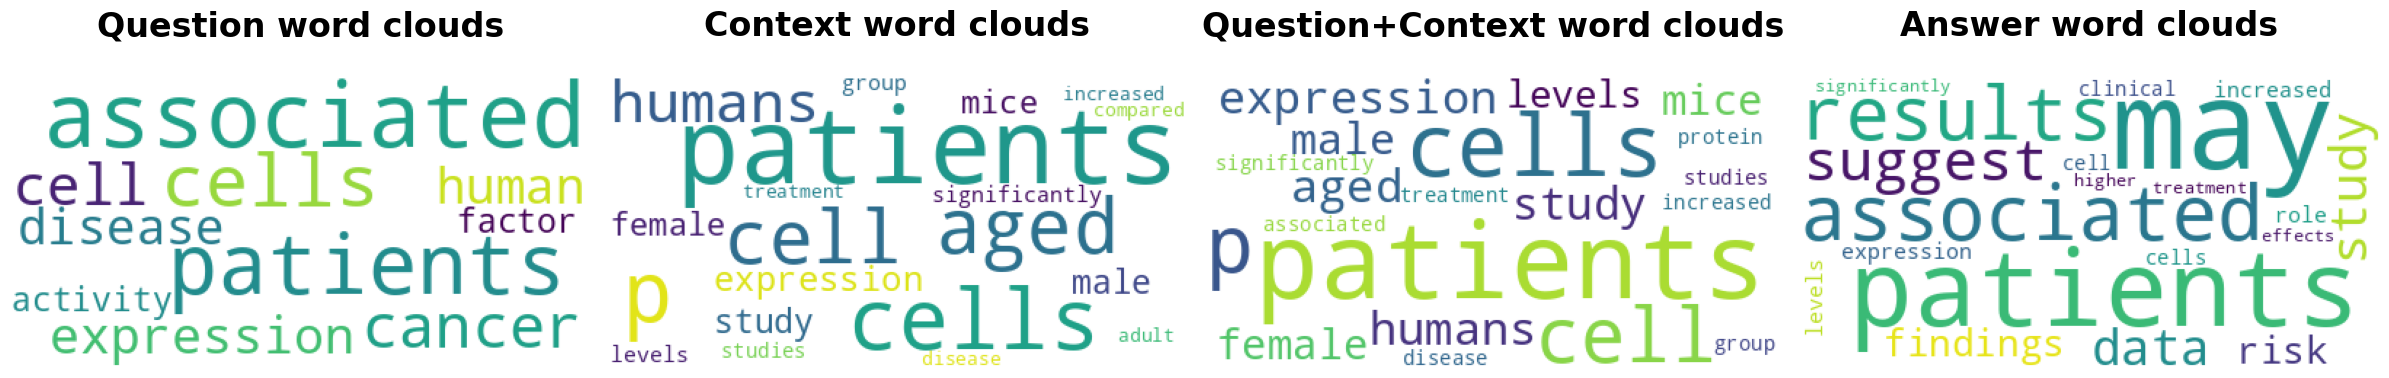

In [ ]:
wordcloud_question = WordCloud(background_color='white').generate_from_frequencies(dict(question_counts.most_common(10)))
wordcloud_context = WordCloud(background_color='white').generate_from_frequencies(dict(context_counts.most_common(M)))
wordcloud_input = WordCloud(background_color='white').generate_from_frequencies(dict(input_counts.most_common(M)))
wordcloud_answer = WordCloud(background_color='white').generate_from_frequencies(dict(answer_counts.most_common(M)))

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(24,6))
ax = axs[0]
ax.imshow(wordcloud_question)
ax.set_title('Question word clouds', pad=30, fontsize=24, fontweight="bold")
ax.axis('off')
ax = axs[1]
ax.imshow(wordcloud_context)
ax.set_title('Context word clouds', pad=30, fontsize=24, fontweight="bold")
ax.axis('off')
ax = axs[2]
ax.imshow(wordcloud_input)
ax.set_title('Question+Context word clouds', pad=30, fontsize=24, fontweight="bold")
ax.axis('off')
ax = axs[3]
ax.imshow(wordcloud_answer)
ax.set_title('Answer word clouds', pad=30, fontsize=24, fontweight="bold")
ax.axis('off')
plt.tight_layout();

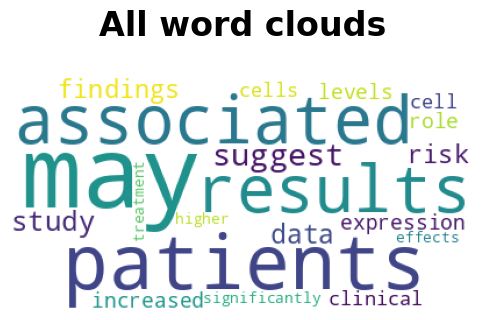

In [ ]:
wordcloud_all = WordCloud(background_color='white').generate_from_frequencies(dict(all_counts.most_common(M)))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
ax.imshow(wordcloud_all)
ax.set_title('All word clouds', pad=30, fontsize=24, fontweight="bold")
ax.axis('off');

### Vocabulary

For the vocabulary analysis, I merge all the input and outputs to gather the overall vocabulary and I do not consider the stopwords:

In [ ]:
all_split = split_and_clean_docs(
    list(df_a["question"].loc[sampled_idxs]) + list(df_a["long_answer"].loc[sampled_idxs]) + list(df_a["context"].loc[sampled_idxs]),
    remove_stopwords=True)
vocab = set(all_split)
print("Vocabulary length:", len(vocab))

Vocabulary length: 23872


In [ ]:
vocab_per_sample_df = pd.DataFrame(index=df_a.loc[sampled_idxs].index, columns=["vocab"])
for row in df_a.loc[sampled_idxs].itertuples(index=True):
    docs = [row.question, row.context, row.long_answer]
    sample_vocab = set(split_and_clean_docs(docs, remove_stopwords=True))
    vocab_per_sample_df.loc[row.Index, "vocab"] = sample_vocab

In [ ]:
vocab_len_per_sample = vocab_per_sample_df["vocab"].apply(lambda x: len(x))

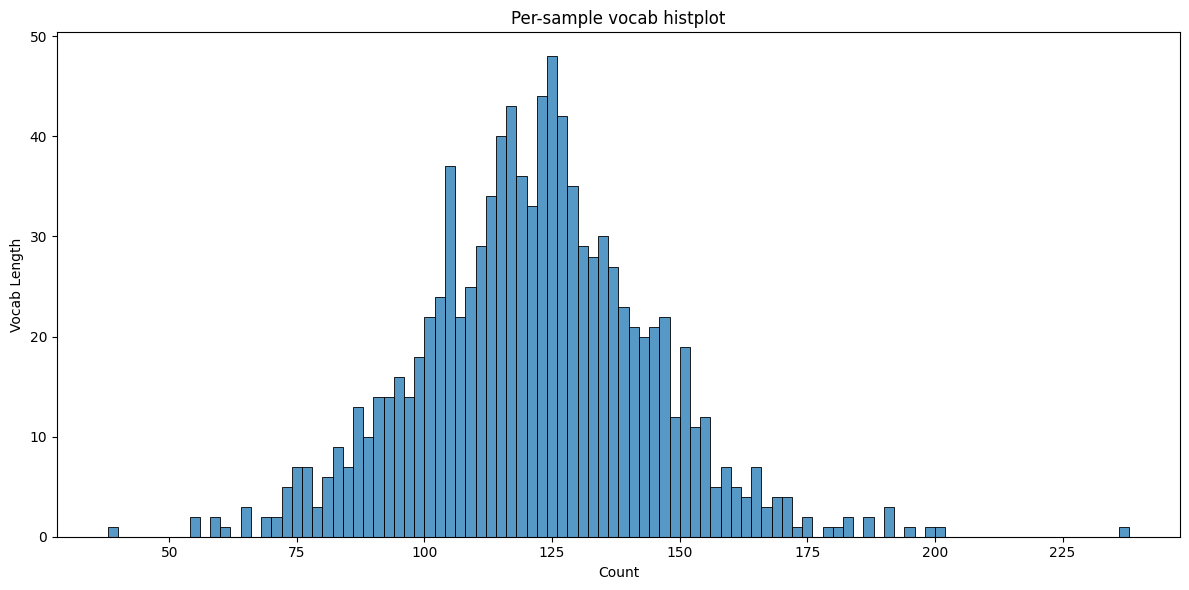

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(vocab_len_per_sample, bins=100)
plt.xlabel('Count')
plt.ylabel('Vocab Length')
plt.title("Per-sample vocab histplot")
plt.tight_layout()

In [ ]:
print(f'Number of entries: {len(df_a["question"])}\n')

print("Per-sample vocab length:")
print(f'Average: {np.mean(vocab_len_per_sample).round(2)}')
print(f'Minimum: {np.min(vocab_len_per_sample)}')
print(f'Maximum: {np.max(vocab_len_per_sample)}\n')

Number of entries: 211269

Per-sample vocab length:
Average: 121.12
Minimum: 38
Maximum: 238



In [ ]:
l = []
s = []
steps = range(0, 2000, 100)

for n in steps:
    print(n)
    all_split = split_and_clean_docs(
        list(df_a["question"].sample(n, replace=False, random_state=SEED)) + list(df_a["long_answer"].sample(n, replace=False, random_state=SEED)) + list(df_a["context"].sample(n, replace=False, random_state=SEED)),
        remove_stopwords=True)
    l.append(len(set(all_split)))
    s.append(len(all_split))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


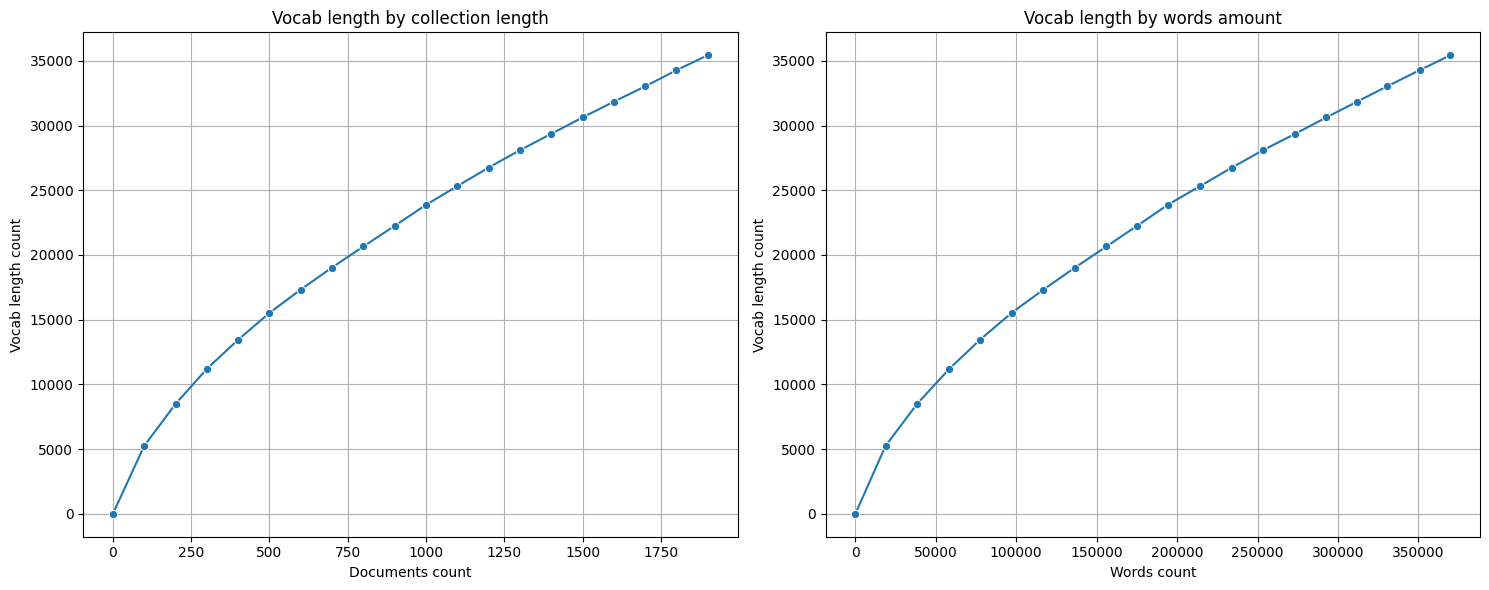

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
ax = axs[0]
sns.lineplot(x=steps, y=l, marker="o", ax=ax)
ax.set_title("Vocab length by collection length")
ax.grid(True)
ax.set_xlabel('Documents count')
ax.set_ylabel('Vocab length count')
ax = axs[1]
sns.lineplot(x=s, y=l, marker="o", ax=ax)
ax.set_title("Vocab length by words amount")
ax.set_xlabel('Words count')
ax.set_ylabel('Vocab length count')
ax.grid(True)
plt.tight_layout()

Empirically, we can show the presence of **Heap's law**, even though considering more documents for the trend might show the law trend more clearly.

The following histogram displays the word length distribution:

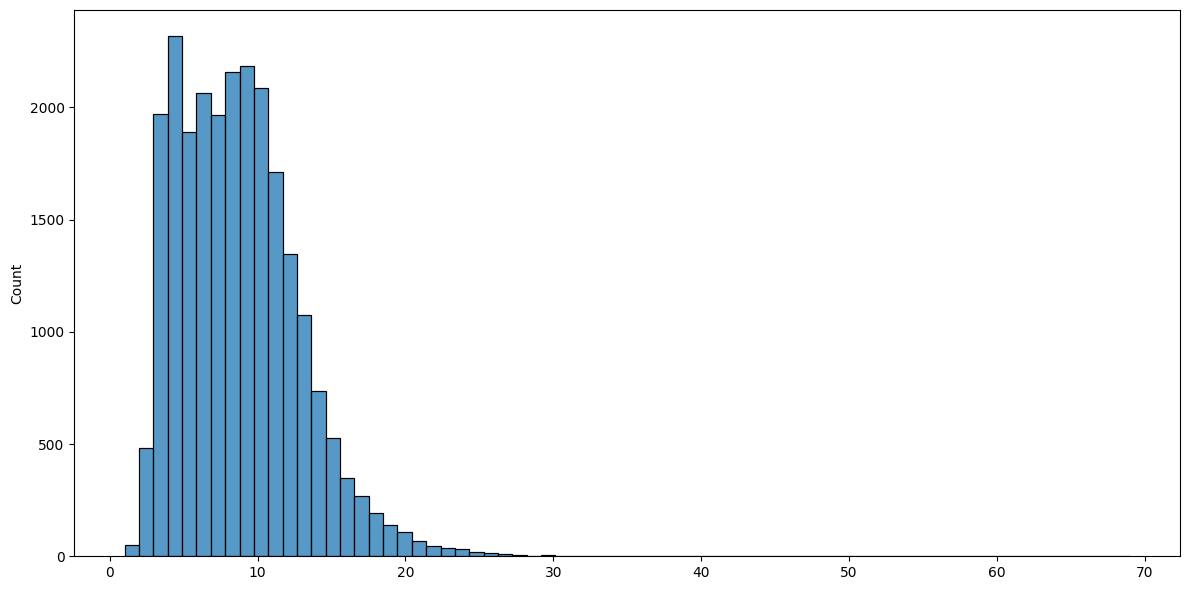

In [ ]:
len_per_word = [len(w) for w in vocab]
plt.figure(figsize=(12, 6))
sns.histplot(len_per_word, bins=70)
plt.tight_layout()

The longest words are suspicious, let's check them:

In [ ]:
len_sorted_idxs = np.array(len_per_word).argsort()
np.array(list(vocab))[len_sorted_idxs[:-10:-1]]

array(['345dimethylthiazol2yl53carboxymethoxyphenyl24sulfophenyl2htetrazolium',
       '23bis2methoxy4nitro5sulfophenyl2htetrazolium5carboxanilide',
       '11dioctadecyl3333tetramethylindocarbocyaninelabelled',
       '24carboxyphenyl4455tetramethylimidazoline1oxyl3oxide',
       '14dihydro26dimethyl5nitro42trifluoromethylphenyl',
       '17dimethylaminoethylamino17demethoxygeldanamycin',
       'alphaamino3hydroxy5methyl4isoxazolepropionic',
       '345dimethylthiazol2yl25diphenyltetrazolium',
       'morpholin4ium4methoxyphenylmorpholino'], dtype='<U69')

They are names from a chemical domain, hence we will consider them valid words.